# ちょっとした説明

【概要】

東京都オープンデータカタログデータサイトから、

東京都の新型コロナ陽性患者に関するデータをダウンロードし、

新規感染者数の推移をグラフとカレンダーにまとめて出力するスクリプトです。

データ：https://catalog.data.metro.tokyo.lg.jp/dataset/t000010d0000000068


【準備】

以下のブログを参考に、seleniumとChromeDriverをインストールしてください。

https://qiita.com/kinpira/items/383b0fbee6bf229ea03d


chromedriverはこのスクリプトと同じディレクトリにコピーしてください。


【実行】

この.ipynbを実行するだけでおけです。

# 出力したいカレンダーの月を指定してください
（一ヶ月分しか指定できません、すみません）

In [225]:
year = 2020
month = 4

# 準備（データ取得と加工）

In [226]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import datetime
import time
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import calendar

from selenium import webdriver

In [227]:
# カレントディレクトリのパス取得
current_path = os.getcwd()

# 取得ファイル名
data_name = '130001_tokyo_covid19_patients.csv'

# すでにファイルがあれば削除
if os.path.exists(os.path.join(current_path, '130001_tokyo_covid19_patients.csv')):
    os.remove(data_name)

# 今日の日付取得
today  = datetime.date.today()

# データ取得
chromeOptions = webdriver.ChromeOptions()
prefs = {"download.default_directory" : current_path}
chromeOptions.add_experimental_option("prefs",prefs)
driver = webdriver.Chrome(os.path.join(current_path, 'chromedriver'), chrome_options=chromeOptions)
driver.get('https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv')
time.sleep(4)
driver.close()

# データの加工
df = pd.read_csv('130001_tokyo_covid19_patients.csv')
grouped_count = df.groupby('公表_年月日').count()
date_range = (today - datetime.date(2020, 1, 24)).days
dates_DF = pd.DataFrame(index=pd.date_range('2020-01-24', periods=date_range, freq='D'))
grouped_count=  grouped_count.merge(dates_DF, how="outer", left_index=True, right_index=True)
infected_transition = grouped_count['No'].fillna(0)
week_movement_mean = infected_transition.rolling(window=7).mean().fillna(0)

# 東京の新規感染者推移

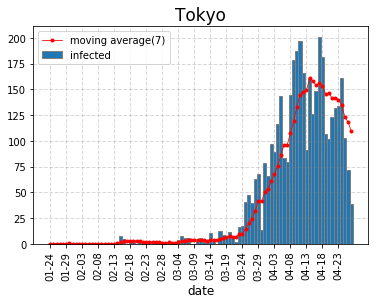

In [232]:
fig, ax = plt.subplots(subplot_kw=({"xticks":(np.arange(datetime.date(2020, 1, 24), today-datetime.timedelta(1), datetime.timedelta(5)))}))


x_label = infected_transition.index.tolist()
y1 = infected_transition.values.tolist()
y2 = week_movement_mean.values.tolist()

ax.set_title("Tokyo", fontsize = 17)

ax.bar(x_label, y1, width=1, label="infected", edgecolor="gray")
ax.plot(x_label, y2, linewidth=0.8, color='red',
        marker="o", markersize=3, markeredgewidth=1, markeredgecolor="red", markerfacecolor="red",
        label="moving average(7)")
ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
ax.grid(which = "major", axis = "x", color = "grey", alpha = 0.3,
        linestyle = "--", linewidth = 1)
ax.grid(which = "major", axis = "y", color = "grey", alpha = 0.3,
        linestyle = "--", linewidth = 1)

# 凡例
ax.legend(loc=0)
plt.xticks(rotation=90)
plt.xlabel('date', fontsize = 12)
plt.savefig('tokyo.png') 
plt.show()

# 東京コロナカレンダー

In [233]:
df = pd.DataFrame(np.arange(70).reshape(10, 7),
                  columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                  index=['1st', '', '2nd', '', '3rd', '', '4th', '', '5th', ''])

In [234]:
week_list = calendar.monthcalendar(year, month)

ins = 1
for _ in range(len(week_list)):
    week_list.insert(ins, [ 0,  0,  0,  0,  0,  0,  0])
    ins = ins + 2

df = pd.DataFrame(np.array(week_list),
                  columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                  index=['1st', '', '2nd', '', '3rd', '', '4th', '', '5th', ''])
df = df.replace(0, -1)

In [235]:
infected_week = infected_transition[(infected_transition.index >= datetime.datetime(year,month,1)) & 
                                    (infected_transition.index< datetime.datetime(year,month+1,1))]

In [236]:
day_index = 1
day_col = calendar.monthrange(year, month)[0]

for i in range(len(infected_week)):
    df.iloc[day_index, day_col] = infected_week[i]
    
    if(i != 0 and df.columns[day_col] == 'Sun'):
        day_col = -1
        day_index = day_index + 2

    day_col = day_col+1

In [237]:
df = df.astype('int')
df = df.astype('str')
df = df.replace('-1', '')

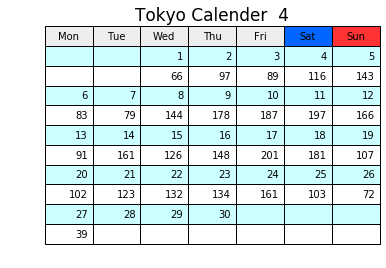

In [238]:
colors = [
    ["#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF"],
    [ "w","w","w","w","w","w","w"],
    ["#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF"],
    [ "w","w","w","w","w","w","w"],
    ["#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF"],
    [ "w","w","w","w","w","w","w"],
    ["#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF"],
    [ "w","w","w","w","w","w","w"],
    ["#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF","#CCFFFF"],
    [ "w","w","w","w","w","w","w"]
]

fig, ax = plt.subplots()
ax.set_title("Tokyo Calender  " + str(month), fontsize = 17)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=df.values,
         colLabels=df.columns,
         loc='center',
         cellColours=colors,
         colColours=[ "#EEEEEE","#EEEEEE","#EEEEEE","#EEEEEE","#EEEEEE","#0066FF","#FF3333"],
         bbox=[0,0,1,1])

plt.savefig('table.png')